#
#
#
#
#
#
#
TODO
Add in plots of all features to see distributions
Apply transformations to variables to regularize data. E.g. scale variance and mean so all paramters are on similar footing
Explore classifer options (e.g. bootstrapping)
Explore alternative classifiers
#
#
#
#
#
#
#

In [413]:
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#dates
import datetime

df=pd.read_csv("SpotifyData.csv", encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [414]:
#begin tidying up data starting with data types
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

#check for missing data
missing_value_count = df.isnull().sum()
print(missing_value_count)

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  1
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [415]:
#remove missing data (not worried about shazam..)
df.dropna(subset=['key','streams'],inplace=True)
missing_value_count = df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 857 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            857 non-null    object 
 1   artist(s)_name        857 non-null    object 
 2   artist_count          857 non-null    int64  
 3   released_year         857 non-null    int64  
 4   released_month        857 non-null    int64  
 5   released_day          857 non-null    int64  
 6   in_spotify_playlists  857 non-null    int64  
 7   in_spotify_charts     857 non-null    int64  
 8   streams               857 non-null    float64
 9   in_apple_playlists    857 non-null    int64  
 10  in_apple_charts       857 non-null    int64  
 11  in_deezer_playlists   857 non-null    object 
 12  in_deezer_charts      857 non-null    int64  
 13  in_shazam_charts      816 non-null    object 
 14  bpm                   857 non-null    int64  
 15  key                   857 no

In [416]:
#map text variables to numeric values for use in classifiers
keySignatureMap={"A":0,
"A#":1,
"B":2,
"C":3,
"C#":4,
"D":5,
"D#":6,
"E":7,
"F":8,
"F#":9,
"G":10,
"G#":11,
}
modeMap={"Major":1,"Minor":0}
df["key"]=df["key"].apply(lambda x: keySignatureMap[x])
df["mode"]=df["mode"].apply(lambda x: modeMap[x])

In [417]:
#use date to determine day of the week for release
df["released_weekday"]=df.apply(lambda x: datetime.date(x['released_year'], x["released_month"], x["released_day"]).weekday() , axis=1)
print(df["released_weekday"])

0      4
1      3
2      4
3      4
4      3
      ..
948    3
949    4
950    3
951    3
952    4
Name: released_weekday, Length: 857, dtype: int64


In [418]:
# begin analysis
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_charts,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,released_weekday
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,8.570000e+02,857.000000,857.000000,857.000000,...,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,1.551925,2018.297550,6.031505,13.739790,5204.997666,11.959160,5.133554e+08,67.383897,51.044341,2.619603,...,5.911319,0.553092,67.273046,51.219370,64.339557,26.644107,1.611435,18.175029,10.396733,3.281214
std,0.864634,10.991135,3.567138,9.287652,7944.032885,19.194211,5.714855e+08,86.562405,50.407409,5.770938,...,3.556168,0.497464,14.653159,23.594579,16.056348,25.688111,8.570734,13.569471,10.090890,1.363419
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000,0.000000
25%,1.000000,2020.000000,3.000000,5.000000,859.000000,0.000000,1.391938e+08,13.000000,7.000000,0.000000,...,4.000000,0.000000,57.000000,32.000000,53.000000,5.000000,0.000000,10.000000,4.000000,3.000000
50%,1.000000,2022.000000,5.000000,13.000000,2226.000000,3.000000,2.849083e+08,34.000000,38.000000,0.000000,...,6.000000,1.000000,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000,4.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,6.740727e+08,85.000000,85.000000,2.000000,...,9.000000,1.000000,78.000000,70.000000,76.000000,42.000000,0.000000,24.000000,12.000000,4.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,46.000000,...,11.000000,1.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,6.000000


In [419]:
#list top 5 streamed songs of all time
df.sort_values(by=['streams'],ascending=False,inplace=True)
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,released_weekday
55,Blinding Lights,The Weeknd,1,2019,11,29,43899,69,3.703895e+09,672,...,4,1,50,38,80,0,0,9,7,4
179,Shape of You,Ed Sheeran,1,2017,1,6,32181,10,3.562544e+09,33,...,4,0,83,93,65,58,0,9,8,4
86,Someone You Loved,Lewis Capaldi,1,2018,11,8,17836,53,2.887242e+09,440,...,4,1,50,45,41,75,0,11,3,3
620,Dance Monkey,Tones and I,1,2019,5,10,24529,0,2.864792e+09,533,...,9,0,82,54,59,69,0,18,10,4
41,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2,2018,10,9,24094,78,2.808097e+09,372,...,5,1,76,91,50,54,0,7,5,1


In [420]:
#define a mega hit as anything with above average streams (note, not 50% of hits as non Gaussian distribution)
#this will be our metric for success
meanStreams=np.mean(df['streams'])
df["megaHit"]=df["streams"].apply(lambda x: 1 if x>meanStreams else 0)

#define features for use in classification
Y=df["megaHit"]
featureNames=["artist_count",
"released_year", #obviously strongly correlated with streams, but is it actually useful for deciding when to release...?
"released_month",
"released_day",
"released_weekday",
"bpm",
"key",
"mode",
#"danceability_%",
"valence_%",
#"energy_%",
"acousticness_%",
"instrumentalness_%",
"liveness_%",
"speechiness_%",
]
X=df[featureNames]
X.describe()

,artist_count,released_year,released_month,released_day,released_weekday,bpm,key,mode,valence_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,1.551925,2018.297550,6.031505,13.739790,3.281214,122.842474,5.911319,0.553092,51.219370,26.644107,1.611435,18.175029,10.396733
std,0.864634,10.991135,3.567138,9.287652,1.363419,28.196567,3.556168,0.497464,23.594579,25.688111,8.570734,13.569471,10.090890
min,1.000000,1930.000000,1.000000,1.000000,0.000000,65.000000,0.000000,0.000000,4.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,5.000000,3.000000,100.000000,4.000000,0.000000,32.000000,5.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,5.000000,13.000000,4.000000,121.000000,6.000000,1.000000,51.000000,17.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,4.000000,142.000000,9.000000,1.000000,70.000000,42.000000,0.000000,24.000000,12.000000
max,8.000000,2023.000000,12.000000,31.000000,6.000000,206.000000,11.000000,1.000000,97.000000,97.000000,91.000000,97.000000,64.000000


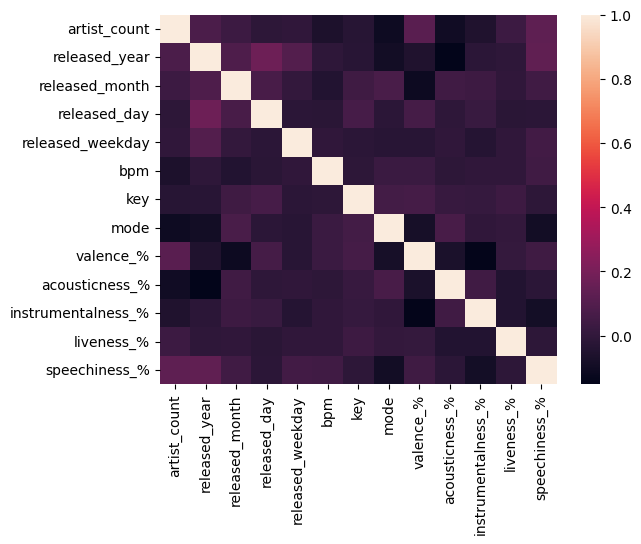

In [421]:
#examine feature correlations
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix = X.corr()
sn.heatmap(corr_matrix, annot=False)
plt.show()

In [422]:
# Create a random forest classifier
classifier = RandomForestClassifier()

#define a hyperparamter space
param_dist = {'n_estimators': randint(50,500), #number of trees
              'max_depth': randint(1,20)} #depth of each tree

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(classifier, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Create a variable for the best model
bestClassifier = rand_search.best_estimator_




Best hyperparameters: {'max_depth': 11, 'n_estimators': 211}


Accuracy: 0.7906976744186046
Precision: 0.7
Recall: 0.7


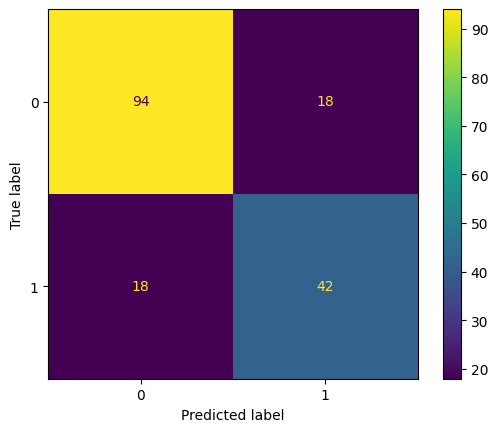

In [423]:
#test optimal classifier and evaluate performance
Y_pred = bestClassifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


<Axes: >

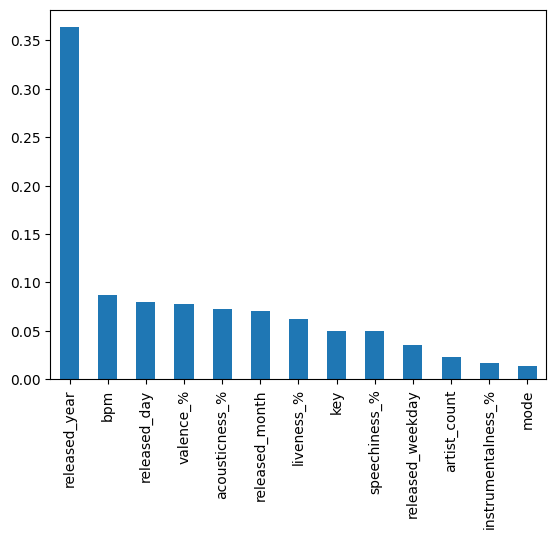

In [424]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(bestClassifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()


In [425]:
#also try looking at simple logistic regression 

import statsmodels.api as sm

logit_model=sm.Logit(Y_train,sm.add_constant(X_train))
result=logit_model.fit()
#print(result.summary())
#print(np.exp(result.params))

conf = result.conf_int()
conf['Odds Ratio'] = result.params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

print("Pvalues= \n",result.pvalues)

Optimization terminated successfully.
         Current function value: 0.572162
         Iterations 6
                              5%           95%    Odds Ratio
const               7.922968e+28  1.592688e+61  1.123335e+45
artist_count        6.326481e-01  9.948418e-01  7.933377e-01
released_year       9.330384e-01  9.680554e-01  9.503857e-01
released_month      9.326452e-01  1.028060e+00  9.791909e-01
released_day        9.832239e-01  1.021010e+00  1.001939e+00
released_weekday    8.320426e-01  1.060730e+00  9.394532e-01
bpm                 9.936503e-01  1.005848e+00  9.997304e-01
key                 9.613194e-01  1.058328e+00  1.008658e+00
mode                6.176209e-01  1.241331e+00  8.755981e-01
valence_%           9.815567e-01  9.965812e-01  9.890404e-01
acousticness_%      9.862203e-01  9.998168e-01  9.929953e-01
instrumentalness_%  9.455421e-01  1.004445e+00  9.745484e-01
liveness_%          9.752006e-01  1.002376e+00  9.886948e-01
speechiness_%       9.662921e-01  1.002670e+

In [426]:
#small example showing how equivalent works with different classifier

from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, Y_train)
#logisticRegr.predict(X_test)

score = logisticRegr.score(X_test, Y_test)
print(score)

0.6511627906976745
